# Extract read counts for most highly expressed transcripts and genes from Madrasin concentration data

## Purpose:
We want to grab the most highly most expressed genes and transcripts from the Madrasin concentration data that has been aligned to the transcriptome using Salmon. 

1. For each file, get the most highly expressed genes and transcripts and compile into a unique list
2. Find the read counts for the all unique highly expressed genes/transcripts across all files
3. Make a heatmap with read counts 

We have included two options: one to remove all the non-coding transcripts and two to specify the number of highly expressed features to look at. 

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [3]:
# Set variable to remove non-coding genes
removeNC=True
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [4]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)


In [5]:
if feature=="Gene":
    fileToRead="quant.genes.sf"
else:
    fileToRead="quant.sf"

In [6]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=50

In [7]:
# Set the variable if 50percent of reads
lessReads=""
#lessReads="_Just50percentReads"

In [9]:
# Get highly expressed features from each file 
top_features = []
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    if "transcripts_quant_genenames"+lessReads in filename and "transcripts_quant_genenames_" not in filename:
        print filename
        # Read the salmon output file
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Sort the data by TPM
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first 100 features
        if numFeatures==0:
            top_features.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

Mad-30mm-8hr-minus_S12_transcripts_quant_genenames
Mad-20mm-8hr-DMS_S8_transcripts_quant_genenames
Mad-10mm-8hr-DMS_S7_transcripts_quant_genenames
Mad-20mm-4hr-DMS_S2_transcripts_quant_genenames
Mad-30mm-4hr-minus_S6_transcripts_quant_genenames
All_Minusfiles_transcripts_quant_genenames
All_DMSfiles_transcripts_quant_genenames
Mad-10mm-4hr-DMS_S1_transcripts_quant_genenames
Mad-30mm-8hr-DMS_S9_transcripts_quant_genenames
Mad-20mm-8hr-minus_S11_transcripts_quant_genenames
Mad-20mm-4hr-minus_S5_transcripts_quant_genenames
Mad-10mm-4hr-minus_S4_transcripts_quant_genenames
Mad-10mm-8hr-minus_S10_transcripts_quant_genenames
Mad-30mm-4hr-DMS_S3_transcripts_quant_genenames


In [10]:
# Get the unique features
print len(top_features)
unique_top_features = list(set(top_features))
print len(unique_top_features)

700
73


In [14]:
# Create a data frame with unique top features as column
feature_readCounts = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts.columns.values)
    if "transcripts_quant_genenames"+lessReads in filename and "transcripts_quant_genenames_" not in filename:
        print filename
        current_columns.append(filename.split("_transcripts")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts = pd.concat([feature_readCounts,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts.columns = current_columns

Mad-30mm-8hr-minus_S12_transcripts_quant_genenames
Mad-20mm-8hr-DMS_S8_transcripts_quant_genenames
Mad-10mm-8hr-DMS_S7_transcripts_quant_genenames
Mad-20mm-4hr-DMS_S2_transcripts_quant_genenames
Mad-30mm-4hr-minus_S6_transcripts_quant_genenames
All_Minusfiles_transcripts_quant_genenames
All_DMSfiles_transcripts_quant_genenames
Mad-10mm-4hr-DMS_S1_transcripts_quant_genenames
Mad-30mm-8hr-DMS_S9_transcripts_quant_genenames
Mad-20mm-8hr-minus_S11_transcripts_quant_genenames
Mad-20mm-4hr-minus_S5_transcripts_quant_genenames
Mad-10mm-4hr-minus_S4_transcripts_quant_genenames
Mad-10mm-8hr-minus_S10_transcripts_quant_genenames
Mad-30mm-4hr-DMS_S3_transcripts_quant_genenames


In [15]:
feature_readCounts = feature_readCounts.iloc[:,range(1,feature_readCounts.shape[1])]
feature_readCounts.index = sorted(unique_top_features)
feature_readCounts.head()

,Mad-30mm-8hr-minus_S12,Mad-20mm-8hr-DMS_S8,Mad-10mm-8hr-DMS_S7,Mad-20mm-4hr-DMS_S2,Mad-30mm-4hr-minus_S6,All_Minusfiles,All_DMSfiles,Mad-10mm-4hr-DMS_S1,Mad-30mm-8hr-DMS_S9,Mad-20mm-8hr-minus_S11,Mad-20mm-4hr-minus_S5,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-30mm-4hr-DMS_S3
ACTB,1419.660,1418.5400,1338.760,1617.670,2264.190,1986.290,1594.370,1784.850,1787.060,1924.070,2530.640,2046.890,1959.640,1346.810
ATP5F1B,113.119,128.0890,104.942,124.856,741.173,607.000,296.140,120.389,759.203,719.034,709.515,741.380,734.175,104.607
CALR,144.686,150.5740,135.634,190.227,586.231,472.857,260.183,156.662,526.828,517.929,586.439,532.294,547.499,145.723
CD48,111.895,81.2849,133.777,138.596,490.071,415.038,210.981,137.830,458.039,651.287,443.548,537.984,388.863,137.577
CDKN1A,137.488,150.8670,542.708,148.800,238.956,349.257,258.294,327.403,176.346,906.274,245.038,413.672,165.798,106.975


In [16]:
# Sort the column names and re-arrange data frame
current_columns = list(feature_readCounts.columns.values)
current_columns_sorted = sorted(current_columns)
print current_columns_sorted
feature_readCounts = feature_readCounts[current_columns_sorted]
feature_readCounts.head()

['All_DMSfiles', 'All_Minusfiles', 'Mad-10mm-4hr-DMS_S1', 'Mad-10mm-4hr-minus_S4', 'Mad-10mm-8hr-DMS_S7', 'Mad-10mm-8hr-minus_S10', 'Mad-20mm-4hr-DMS_S2', 'Mad-20mm-4hr-minus_S5', 'Mad-20mm-8hr-DMS_S8', 'Mad-20mm-8hr-minus_S11', 'Mad-30mm-4hr-DMS_S3', 'Mad-30mm-4hr-minus_S6', 'Mad-30mm-8hr-DMS_S9', 'Mad-30mm-8hr-minus_S12']


,All_DMSfiles,All_Minusfiles,Mad-10mm-4hr-DMS_S1,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-DMS_S7,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-DMS_S2,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-DMS_S8,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-DMS_S3,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9,Mad-30mm-8hr-minus_S12
ACTB,1594.370,1986.290,1784.850,2046.890,1338.760,1959.640,1617.670,2530.640,1418.5400,1924.070,1346.810,2264.190,1787.060,1419.660
ATP5F1B,296.140,607.000,120.389,741.380,104.942,734.175,124.856,709.515,128.0890,719.034,104.607,741.173,759.203,113.119
CALR,260.183,472.857,156.662,532.294,135.634,547.499,190.227,586.439,150.5740,517.929,145.723,586.231,526.828,144.686
CD48,210.981,415.038,137.830,537.984,133.777,388.863,138.596,443.548,81.2849,651.287,137.577,490.071,458.039,111.895
CDKN1A,258.294,349.257,327.403,413.672,542.708,165.798,148.800,245.038,150.8670,906.274,106.975,238.956,176.346,137.488


In [17]:
# If look at all expressed genes, get rid of all features that have zero for all features 
print feature_readCounts.shape
if numFeatures==0:
    feature_readCounts = feature_readCounts[(feature_readCounts.T> 2).any()]
print feature_readCounts.shape

(73, 14)
(73, 14)


In [18]:
# Log the read counts TPM
feature_readCounts_plus1 = feature_readCounts + 1
feature_readCounts_Log = feature_readCounts_plus1.apply(np.log10)
max_val = np.ceil(feature_readCounts_Log.max().max())

In [19]:
min_val = np.floor(feature_readCounts_Log.min().min())

In [27]:
print max_val
print min_val

4.0
1.0


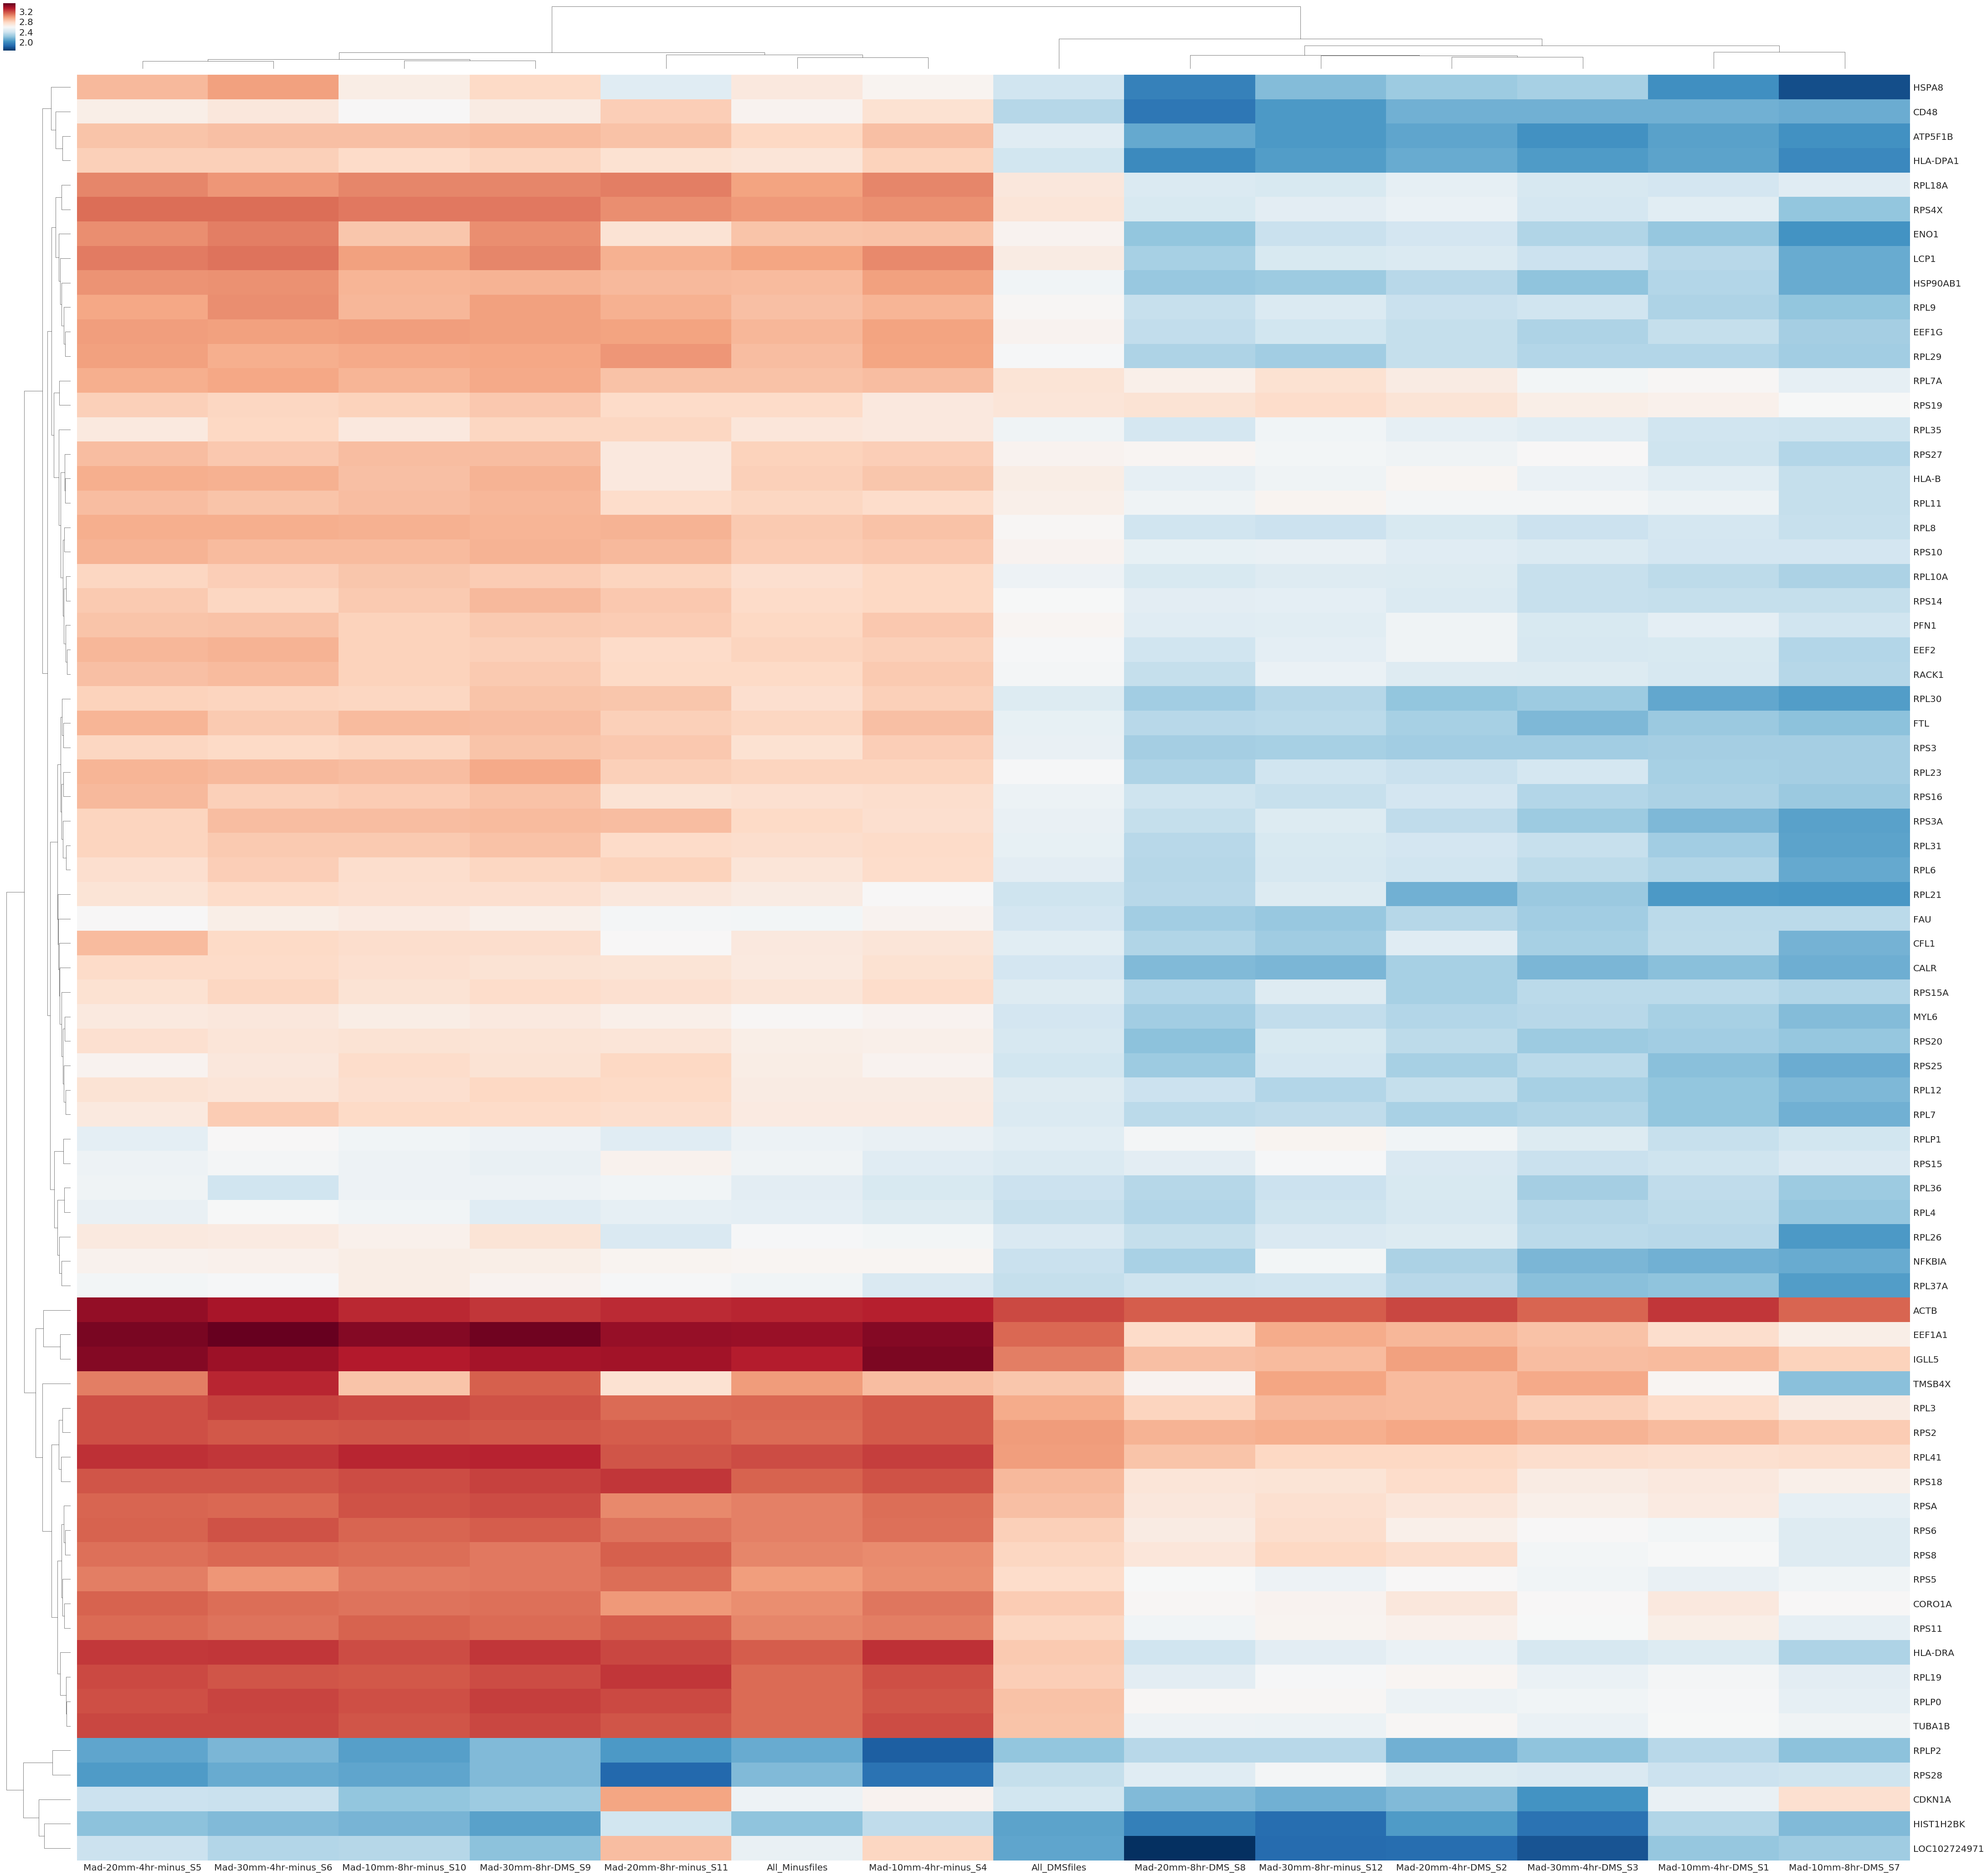

In [28]:
# Plot correlation map
sns.set(font_scale=2)
if numFeatures==0:
    ax = sns.clustermap(feature_readCounts_Log,cmap="RdBu_r",annot=False, square=False, yticklabels=False, figsize=(50,50))
    ax.savefig("../results/HeatMap_Clustered_TPMs_All"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
else:
    ax = sns.clustermap(feature_readCounts_Log,cmap="RdBu_r",annot=False, square=False, yticklabels=True, figsize=(75,75))
    plt.savefig("../results/HeatMap_Clustered_TPMs_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
reordered_indices = ax.dendrogram_row.reordered_ind
reordered_columns = ax.dendrogram_col.reordered_ind
plt.show()

In [29]:
feature_readCounts_Log.head()

,All_DMSfiles,All_Minusfiles,Mad-10mm-4hr-DMS_S1,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-DMS_S7,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-DMS_S2,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-DMS_S8,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-DMS_S3,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9,Mad-30mm-8hr-minus_S12
HSPA8,2.400875,2.689887,2.021251,2.610675,1.768097,2.660923,2.251500,2.889724,1.963259,2.477098,2.277740,2.972610,2.771263,2.183310
CD48,2.326297,2.619133,2.142483,2.731576,2.129616,2.590912,2.144873,2.647919,1.915320,2.814439,2.141691,2.691144,2.661850,2.052675
ATP5F1B,2.472961,2.783904,2.084179,2.870626,2.025068,2.866391,2.099874,2.851573,2.110889,2.857353,2.023693,2.870505,2.880930,2.057358
HLA-DPA1,2.409287,2.706447,2.091583,2.799697,1.987581,2.768470,2.120613,2.806524,1.997878,2.732300,2.060040,2.811047,2.799003,2.068946
RPL18A,2.693121,2.959174,2.415411,3.038847,2.472723,3.040064,2.508198,3.041637,2.451576,3.063476,2.430630,2.998867,3.042906,2.437822


In [30]:
labels_indices_org = feature_readCounts_Log.index.values
labels_columns_org = feature_readCounts_Log.columns.values

In [31]:
labels_indices_reordered = labels_indices_org[reordered_indices]
labels_columns_reordered = labels_columns_org[reordered_columns]

In [32]:
# Reorder the feature counts indices 
feature_readCounts_Log= feature_readCounts_Log.reindex(labels_indices_reordered)
feature_readCounts_Log = feature_readCounts_Log[labels_columns_reordered]
feature_readCounts_plus1= feature_readCounts_plus1.reindex(labels_indices_reordered)
feature_readCounts_plus1 = feature_readCounts_plus1[labels_columns_reordered]

In [33]:
feature_readCounts_Log.head()

,Mad-20mm-4hr-minus_S5,Mad-30mm-4hr-minus_S6,Mad-10mm-8hr-minus_S10,Mad-30mm-8hr-DMS_S9,Mad-20mm-8hr-minus_S11,All_Minusfiles,Mad-10mm-4hr-minus_S4,All_DMSfiles,Mad-20mm-8hr-DMS_S8,Mad-30mm-8hr-minus_S12,Mad-20mm-4hr-DMS_S2,Mad-30mm-4hr-DMS_S3,Mad-10mm-4hr-DMS_S1,Mad-10mm-8hr-DMS_S7
HSPA8,2.889724,2.972610,2.660923,2.771263,2.477098,2.689887,2.610675,2.400875,1.963259,2.183310,2.251500,2.277740,2.021251,1.768097
CD48,2.647919,2.691144,2.590912,2.661850,2.814439,2.619133,2.731576,2.326297,1.915320,2.052675,2.144873,2.141691,2.142483,2.129616
ATP5F1B,2.851573,2.870505,2.866391,2.880930,2.857353,2.783904,2.870626,2.472961,2.110889,2.057358,2.099874,2.023693,2.084179,2.025068
HLA-DPA1,2.806524,2.811047,2.768470,2.799003,2.732300,2.706447,2.799697,2.409287,1.997878,2.068946,2.120613,2.060040,2.091583,1.987581
RPL18A,3.041637,2.998867,3.040064,3.042906,3.063476,2.959174,3.038847,2.693121,2.451576,2.437822,2.508198,2.430630,2.415411,2.472723


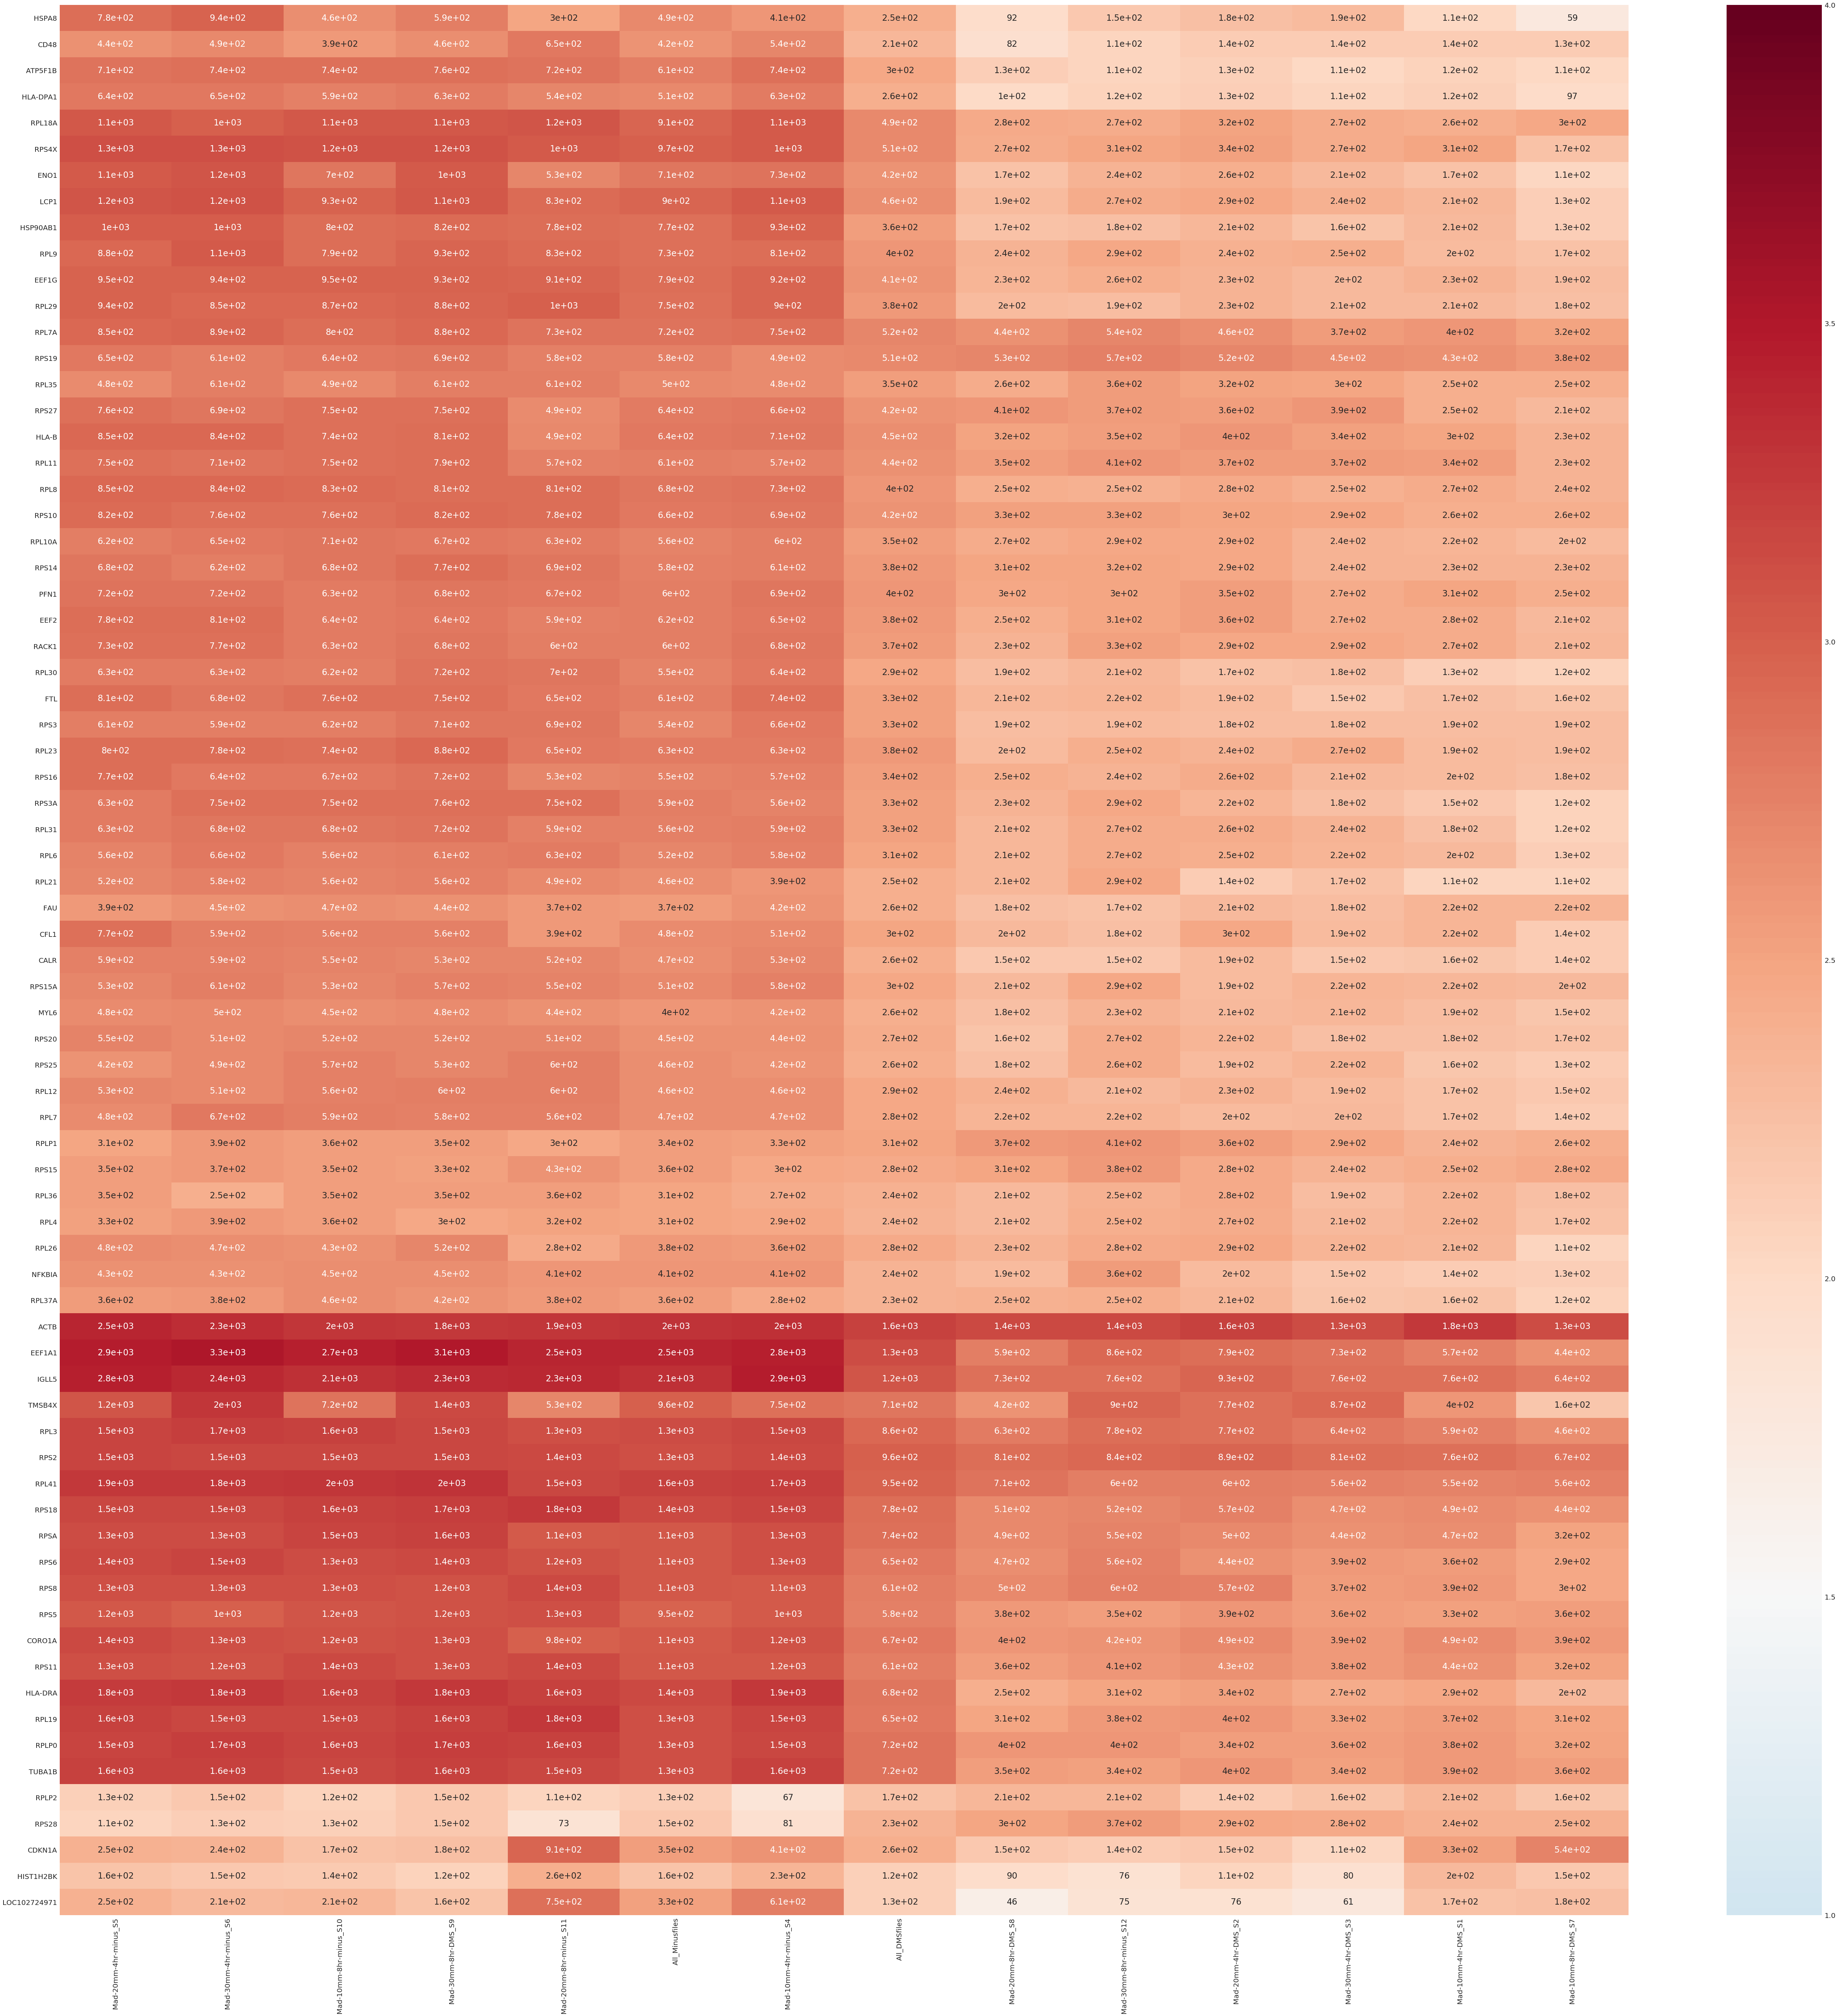

In [34]:
# Plot heatmap
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(100,100))
if numFeatures==0:
    sns.heatmap(feature_readCounts_Log,cmap="RdBu_r",vmax=max_val,vmin=min_val,yticklabels=False,center=(max_val-min_val)/2.0, ax=ax)
    plt.savefig("../results/HeatMap_TPMs_All"+removeNC_string+feature+"s"+featuresWithIntrons_string+lessReads+".png")
else:
    sns.heatmap(feature_readCounts_Log,cmap="RdBu_r",vmax=max_val,vmin=min_val,annot=feature_readCounts_plus1.values,yticklabels=True,center=(max_val-min_val)/2.0, ax=ax)
    plt.savefig("../results/HeatMap_TPMs_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+lessReads+".png")
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90 )
#plt.tight_layout()
plt.show()

In [ ]:
# Get column names that don't have minus in them
allcol_names = list(feature_readCounts_Log.columns.values)
colnames_DMS = [i for i in allcol_names if "DMS" in i]
print colnames_DMS

In [ ]:
# Get data frame that only has DMS data
feature_readCounts_Log_JustDMS = feature_readCounts_Log[colnames_DMS]
feature_readCounts_plus1_JustDMS = feature_readCounts_plus1[colnames_DMS]

In [ ]:
max_val = np.ceil(feature_readCounts_Log_JustDMS.max().max())
min_val = np.floor(feature_readCounts_Log_JustDMS.min().min())

In [ ]:
# Plot heatmap for only DMS data
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(100,100))
if numFeatures==0:
    sns.heatmap(feature_readCounts_Log_JustDMS,cmap="RdBu_r",vmax=max_val,vmin=min_val,yticklabels=False,center=(max_val-min_val)/2.0, ax=ax)
    plt.savefig("../results/HeatMap_TPMs_All"+removeNC_string+feature+"s"+featuresWithIntrons_string+lessReads+"_JustDMS.png")
else:
    sns.heatmap(feature_readCounts_Log_JustDMS,cmap="RdBu_r",vmax=max_val,vmin=min_val,annot=feature_readCounts_plus1_JustDMS.values,yticklabels=True,center=(max_val-min_val)/2.0, ax=ax)
    plt.savefig("../results/HeatMap_TPMs_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+lessReads+"_JustDMS.png")
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90 )
#plt.tight_layout()
plt.show()